This file contains python code to test 
what is the best way to use the MEG data.

- PSD or time-series?

- Raw or stdz

- if PSD, dB or orgianl scale

It seems the best way is to use the standardized time seiers.

In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange
from scipy.io import loadmat
from pprint import pprint

plt.style.use('ggplot')
plt.rcParams["savefig.bbox"] = "tight"

In [3]:
import importlib
import models.linear_model 
importlib.reload(models.linear_model)

<module 'models.linear_model' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/models/linear_model.py'>

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization

from penalties.scad_pen import SCAD
from models.logistic_model import LogisticModel
from models.linear_model import LinearModel


In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Param and fns

### Params

In [12]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 20
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]
paras.ind_freq = np.linspace(1, 40, 40) # freqs
paras.init_noise_sd = 10 # the sd of the noise added to the true value for initial values
paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
#paras.SIS_ratio = 0.4 # the ratio to keep with SIS procedure

# generating dataset
paras.n = 180 # num of data obs to be genareted
paras.npts = 1200 # num of pts to evaluate X(s)
paras.d = 2 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 1 # variance of the error
paras.types_ = ["int", 2, 2, "c", "c"]

# b-spline
paras.N = 10 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.DoubleTensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord))
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([5, 1, -2, 3, -4])

# first way
#beta_type_GT = [fn1, fn2, fn2] + [zero_fn]*(paras.d-3-2) + [fn1, fn2]
#paras.beta_GT = np.array([_fn(paras.x) for _fn in beta_type_GT]).T
# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
#paras.fourier_basis_coefs = ([coef_fn(0.1), coef_fn(0.3), coef_fn(0.5)] + 
#                             [np.zeros(50)] * (paras.d-3-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
#paras.fourier_basis_coefs = ([np.zeros(50)] * (paras.d-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
paras.fourier_basis_coefs = ([np.zeros(50)] * paras.d)
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs
#
paras.Gam_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.sel_idx = np.arange(2, paras.d) # M^c set, 
#without loss of generality, we assume the idxs in M is the first m betas
paras.num_cv_fold = 5
paras.Rfct = 2
paras.stop_cv = 5e-4
paras.max_iter = 2000

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
paras.r, paras.m = paras.Cmat.shape
paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector


The number of B-spline basis is 10.


### Fns

In [13]:

def MS2idxs(q, N, MS_unions):
    """This fn is to return the idxs to keep in mat Q, Sigma and vec Theta
    """
    idxs_all = [np.arange(0, q)]
    for cur_idx in MS_unions:
        idxs_all.append(np.arange(q+cur_idx*N, q+(cur_idx+1)*N))
    idxs_all = np.concatenate(idxs_all)
    return idxs_all

In [14]:
def get_Amat(k, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        paras: parameters
                required: N, Cmat, m, q
    """
    _paras = edict(paras.copy())
    
    part1 = np.kron(_paras.Cmat, np.eye(_paras.N))
    part2 = np.zeros((_paras.m*_paras.N, _paras.q+(_paras.m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+_paras.m*_paras.N)] = np.eye(_paras.m*_paras.N)
    A = part1 @ part2
    return A

In [18]:
def _gen_simu_data_all(seed, paras):
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    
    simu_psd = gen_simu_ts(_paras.n, _paras.d, 5, decimate_rate=30)
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_psd[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    # Y 
    rvs = np.random.rand(_paras.n)
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # To torch
    X = torch.tensor(simu_psd) # n x d x npts
    Z = torch.tensor(simu_covs) # n x q
    Y = torch.tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    all_data.lin_term = lin_term
    return all_data

## Simu

In [22]:
seed = 0
T_vs = []
T_p1s = []
Psis = []
nonzero_idxss = []
for seed in trange(100):

    _paras = edict(paras.copy())
    _paras.seed = seed
    cur_data = _gen_simu_data_all(_paras.seed, _paras )
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
        
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    model._linear_term_der()
    Xt = model.lin_tm_der # Mx(q+dN)
    est_theta = svd_inverse(Xt.T @ Xt + 0*torch.eye(Xt.shape[-1]))@Xt.T@cur_data_SIS.Y
    ##est_theta = torch.inverse(Xt.T @ Xt)@Xt.T@Y
    #
    est_alp = est_theta[:_paras.q]
    est_Gam = col_vec2mat_fn(est_theta[_paras.q:], nrow=_paras.N)*np.sqrt(_paras.N)
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
        
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.tensor(get_Amat(k, _paras))
        
    # calcuate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    Q_mat_part_inv = svd_inverse(Q_mat_part)
        
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
        
    T_p1 = Amat @ est_theta[keep_idxs_test]
    Psi_inv = svd_inverse(Psi)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    print(T_v)

    Psis.append(Psi)
    T_p1s.append(T_p1)
    T_vs.append(T_v.item())
    nonzero_idxss.append(nonzero_idxs)

  1%|█▋                                                                                                                                                                       | 1/100 [00:00<00:56,  1.74it/s]

tensor(26.3907)


  2%|███▍                                                                                                                                                                     | 2/100 [00:01<00:58,  1.67it/s]

tensor(20.9848)


  3%|█████                                                                                                                                                                    | 3/100 [00:01<00:48,  2.00it/s]

tensor(9.4980)


  4%|██████▊                                                                                                                                                                  | 4/100 [00:02<00:46,  2.08it/s]

tensor(30.1757)


  5%|████████▍                                                                                                                                                                | 5/100 [00:02<00:42,  2.24it/s]

tensor(26.5112)


  6%|██████████▏                                                                                                                                                              | 6/100 [00:02<00:40,  2.35it/s]

tensor(36.4792)


  7%|███████████▊                                                                                                                                                             | 7/100 [00:03<00:39,  2.34it/s]

tensor(9.8240)


  8%|█████████████▌                                                                                                                                                           | 8/100 [00:03<00:36,  2.51it/s]

tensor(20.2817)


  9%|███████████████▏                                                                                                                                                         | 9/100 [00:04<00:38,  2.37it/s]

tensor(9.6393)


 10%|████████████████▊                                                                                                                                                       | 10/100 [00:04<00:38,  2.32it/s]

tensor(16.8836)


 11%|██████████████████▍                                                                                                                                                     | 11/100 [00:04<00:36,  2.44it/s]

tensor(20.0045)


 12%|████████████████████▏                                                                                                                                                   | 12/100 [00:05<00:38,  2.26it/s]

tensor(22.7537)


 13%|█████████████████████▊                                                                                                                                                  | 13/100 [00:05<00:42,  2.03it/s]

tensor(17.1533)


 14%|███████████████████████▌                                                                                                                                                | 14/100 [00:06<00:43,  1.99it/s]

tensor(18.3042)


 15%|█████████████████████████▏                                                                                                                                              | 15/100 [00:06<00:40,  2.09it/s]

tensor(13.3104)


 16%|██████████████████████████▉                                                                                                                                             | 16/100 [00:07<00:39,  2.11it/s]

tensor(21.9052)


 17%|████████████████████████████▌                                                                                                                                           | 17/100 [00:07<00:39,  2.09it/s]

tensor(15.0005)


 18%|██████████████████████████████▏                                                                                                                                         | 18/100 [00:08<00:37,  2.20it/s]

tensor(16.2219)


 19%|███████████████████████████████▉                                                                                                                                        | 19/100 [00:08<00:40,  2.01it/s]

tensor(28.7932)


 20%|█████████████████████████████████▌                                                                                                                                      | 20/100 [00:09<00:41,  1.94it/s]

tensor(11.0375)


 21%|███████████████████████████████████▎                                                                                                                                    | 21/100 [00:09<00:40,  1.97it/s]

tensor(20.4946)


 22%|████████████████████████████████████▉                                                                                                                                   | 22/100 [00:10<00:36,  2.11it/s]

tensor(22.6941)


 23%|██████████████████████████████████████▋                                                                                                                                 | 23/100 [00:10<00:36,  2.10it/s]

tensor(25.1565)


 24%|████████████████████████████████████████▎                                                                                                                               | 24/100 [00:11<00:34,  2.18it/s]

tensor(10.1003)


 25%|██████████████████████████████████████████                                                                                                                              | 25/100 [00:11<00:32,  2.31it/s]

tensor(14.3599)


 26%|███████████████████████████████████████████▋                                                                                                                            | 26/100 [00:12<00:32,  2.25it/s]

tensor(10.8248)


 27%|█████████████████████████████████████████████▎                                                                                                                          | 27/100 [00:12<00:35,  2.09it/s]

tensor(8.3166)


 28%|███████████████████████████████████████████████                                                                                                                         | 28/100 [00:13<00:34,  2.10it/s]

tensor(22.5488)


 29%|████████████████████████████████████████████████▋                                                                                                                       | 29/100 [00:13<00:32,  2.17it/s]

tensor(10.8033)


 30%|██████████████████████████████████████████████████▍                                                                                                                     | 30/100 [00:14<00:33,  2.08it/s]

tensor(22.2607)


 31%|████████████████████████████████████████████████████                                                                                                                    | 31/100 [00:14<00:31,  2.19it/s]

tensor(17.4695)


 32%|█████████████████████████████████████████████████████▊                                                                                                                  | 32/100 [00:14<00:31,  2.14it/s]

tensor(16.5953)


 33%|███████████████████████████████████████████████████████▍                                                                                                                | 33/100 [00:15<00:33,  2.01it/s]

tensor(17.4709)


 34%|█████████████████████████████████████████████████████████                                                                                                               | 34/100 [00:16<00:33,  1.98it/s]

tensor(21.6901)


 35%|██████████████████████████████████████████████████████████▊                                                                                                             | 35/100 [00:16<00:30,  2.13it/s]

tensor(11.5888)


 36%|████████████████████████████████████████████████████████████▍                                                                                                           | 36/100 [00:16<00:30,  2.12it/s]

tensor(11.8396)


 37%|██████████████████████████████████████████████████████████████▏                                                                                                         | 37/100 [00:17<00:32,  1.93it/s]

tensor(28.8544)


 38%|███████████████████████████████████████████████████████████████▊                                                                                                        | 38/100 [00:18<00:33,  1.84it/s]

tensor(18.0723)


 39%|█████████████████████████████████████████████████████████████████▌                                                                                                      | 39/100 [00:18<00:31,  1.94it/s]

tensor(16.0494)


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 40/100 [00:19<00:31,  1.88it/s]

tensor(8.6464)


 41%|████████████████████████████████████████████████████████████████████▉                                                                                                   | 41/100 [00:19<00:28,  2.06it/s]

tensor(26.8402)


 42%|██████████████████████████████████████████████████████████████████████▌                                                                                                 | 42/100 [00:20<00:28,  2.00it/s]

tensor(11.4809)


 43%|████████████████████████████████████████████████████████████████████████▏                                                                                               | 43/100 [00:20<00:28,  2.00it/s]

tensor(32.4770)


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 44/100 [00:21<00:27,  2.02it/s]

tensor(9.9811)


 45%|███████████████████████████████████████████████████████████████████████████▌                                                                                            | 45/100 [00:21<00:27,  1.98it/s]

tensor(8.2100)


 46%|█████████████████████████████████████████████████████████████████████████████▎                                                                                          | 46/100 [00:22<00:28,  1.87it/s]

tensor(20.0342)


 47%|██████████████████████████████████████████████████████████████████████████████▉                                                                                         | 47/100 [00:22<00:26,  2.01it/s]

tensor(6.9569)


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 48/100 [00:23<00:27,  1.91it/s]

tensor(22.5652)


 49%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 49/100 [00:23<00:27,  1.87it/s]

tensor(18.4173)


 50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 50/100 [00:24<00:25,  1.96it/s]

tensor(26.1610)


 51%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 51/100 [00:24<00:25,  1.90it/s]

tensor(21.5735)


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 52/100 [00:25<00:24,  1.96it/s]

tensor(12.8442)


 53%|█████████████████████████████████████████████████████████████████████████████████████████                                                                               | 53/100 [00:25<00:21,  2.23it/s]

tensor(29.8657)


 54%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 54/100 [00:25<00:19,  2.35it/s]

tensor(14.5013)


 55%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 55/100 [00:26<00:19,  2.35it/s]

tensor(26.8413)


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 56/100 [00:26<00:20,  2.19it/s]

tensor(14.9844)


 57%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 57/100 [00:27<00:20,  2.14it/s]

tensor(9.6356)


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 58/100 [00:27<00:17,  2.35it/s]

tensor(40.1773)


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 59/100 [00:28<00:17,  2.37it/s]

tensor(8.2453)


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 60/100 [00:28<00:17,  2.34it/s]

tensor(15.5885)


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 61/100 [00:29<00:17,  2.21it/s]

tensor(12.2721)


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                               | 62/100 [00:29<00:17,  2.22it/s]

tensor(18.3063)


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 63/100 [00:29<00:17,  2.15it/s]

tensor(7.5599)


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 64/100 [00:30<00:17,  2.08it/s]

tensor(23.5300)


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 65/100 [00:31<00:17,  2.03it/s]

tensor(21.8973)


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 66/100 [00:31<00:16,  2.05it/s]

tensor(4.5975)


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 67/100 [00:31<00:16,  2.02it/s]

tensor(19.7319)


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 68/100 [00:32<00:16,  1.98it/s]

tensor(25.2201)


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 69/100 [00:32<00:15,  2.02it/s]

tensor(28.2423)


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 70/100 [00:33<00:14,  2.01it/s]

tensor(7.2225)


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 71/100 [00:33<00:13,  2.09it/s]

tensor(34.7606)


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 72/100 [00:34<00:13,  2.10it/s]

tensor(8.6852)


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 73/100 [00:34<00:13,  2.04it/s]

tensor(18.5382)


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 74/100 [00:35<00:13,  1.87it/s]

tensor(15.2411)


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 75/100 [00:35<00:12,  2.01it/s]

tensor(37.3869)


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 76/100 [00:36<00:11,  2.09it/s]

tensor(11.2779)


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 77/100 [00:36<00:11,  2.06it/s]

tensor(23.6018)


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 78/100 [00:37<00:10,  2.08it/s]

tensor(14.1669)


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 79/100 [00:37<00:10,  2.06it/s]

tensor(9.7990)


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 80/100 [00:38<00:09,  2.22it/s]

tensor(13.5162)


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 81/100 [00:38<00:08,  2.31it/s]

tensor(16.5586)


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 82/100 [00:39<00:07,  2.37it/s]

tensor(8.2894)


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 83/100 [00:39<00:06,  2.45it/s]

tensor(8.5472)


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 84/100 [00:39<00:07,  2.20it/s]

tensor(38.0530)


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 85/100 [00:40<00:07,  2.13it/s]

tensor(8.4784)


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 86/100 [00:41<00:07,  1.91it/s]

tensor(17.4791)


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 87/100 [00:41<00:05,  2.19it/s]

tensor(16.4345)


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 88/100 [00:41<00:05,  2.10it/s]

tensor(16.5600)


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 89/100 [00:42<00:05,  2.15it/s]

tensor(12.3924)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 90/100 [00:42<00:04,  2.32it/s]

tensor(17.7019)


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 91/100 [00:43<00:03,  2.44it/s]

tensor(29.5618)


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 92/100 [00:43<00:03,  2.36it/s]

tensor(11.5492)


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 93/100 [00:43<00:02,  2.33it/s]

tensor(7.3565)


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 94/100 [00:44<00:02,  2.41it/s]

tensor(7.1483)


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 95/100 [00:44<00:02,  2.37it/s]

tensor(14.0122)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 96/100 [00:45<00:01,  2.24it/s]

tensor(18.2795)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 97/100 [00:45<00:01,  2.26it/s]

tensor(14.5131)


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 98/100 [00:46<00:00,  2.08it/s]

tensor(9.5330)


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [00:46<00:00,  1.92it/s]

tensor(6.3379)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]

tensor(4.4350)


In [23]:
est_alp

tensor([ 4.9420,  1.1242, -2.0257,  3.0718, -4.0289])

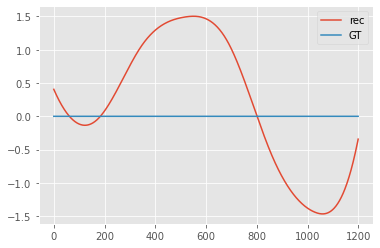

In [24]:
rec_curs = paras.basis_mat @ est_Gam
idx = -1
plt.plot(rec_curs[:, idx], label="rec")
plt.plot(paras.beta_GT[:, idx], label="GT")
plt.legend()

In [25]:
torch.norm(est_Gam, dim=0)

tensor([6.9607, 3.4710])

In [26]:
np.linalg.norm(_paras.Gam_est, axis=0)

array([0., 0.])

<AxesSubplot:>

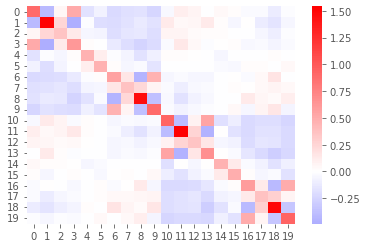

In [27]:
tmp1 = np.mean([ix.numpy() for ix in Psis], axis=0)/paras.n
sns.heatmap(tmp1, center=0, cmap="bwr")

<AxesSubplot:>

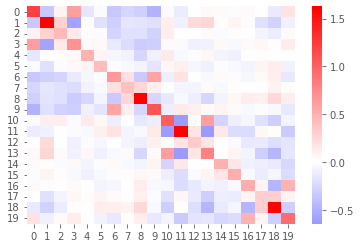

In [28]:
tmp2 = np.cov(np.array([ix.numpy() for ix in T_p1s]).T)
sns.heatmap(tmp2, center=0, cmap="bwr")

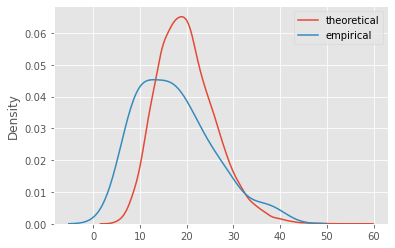

In [29]:
#null_sps = np.random.chisquare(3, 10000)
null_sps = np.random.chisquare(paras.r * paras.N, 10000)
sns.kdeplot(null_sps, label="theoretical")
sns.kdeplot(np.array(T_vs), label="empirical")
plt.legend()

In [30]:
CV = np.quantile(null_sps, 0.95)
np.mean(np.array(T_vs)>CV)

0.06

In [31]:
np.mean(T_vs)

17.43144808561027

In [32]:
np.mean(null_sps)

19.980063291556338